In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Read in data
df = pd.read_csv("/workspaces/Analyzing-Ozone-Pollution-Trends-Across-California/ozone.csv")
df.head()

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
0,/2024,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
1,01/02/2024,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
2,/2024,AQS,60010007,1,NaN,ppm,30.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,January 04/2024,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,January 05/2024,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54759 entries, 0 to 54758
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  54759 non-null  object 
 1   Source                                54759 non-null  object 
 2   Site ID                               54759 non-null  int64  
 3   POC                                   54759 non-null  int64  
 4   Daily Max 8-hour Ozone Concentration  52021 non-null  float64
 5   Units                                 54759 non-null  object 
 6   Daily AQI Value                       52021 non-null  float64
 7   Local Site Name                       54759 non-null  object 
 8   Daily Obs Count                       54759 non-null  int64  
 9   Percent Complete                      54759 non-null  float64
 10  Method Code                           48269 non-null  float64
 11  CBSA Code      

In [32]:
df.shape

(54759, 17)

### Cleaning the date column

Upon examining the date column, I found out that the date is in the format mm/dd/yyy. Though, some dates had their month part in full while some had them in digits.

Also, some of the entries in the column are incomplete like thus: "/2024". I will remove those instances before converting the column to a date data type. 

Converting the column will ensure a consistent format in the column.

In [33]:
# Removing instances of incomplete date
df = df[df['Date'].str.len() >= 10]

# Converting to date time data type
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df.head()

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
1,2024-01-02,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,2024-01-04,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,2024-01-05,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
5,2024-01-06,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
6,2024-01-07,AQS,60010007,1,0.030,ppm,28.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217


In [34]:
df.describe()

,Date,Site ID,POC,Daily Max 8-hour Ozone Concentration,Daily AQI Value,Daily Obs Count,Percent Complete,Method Code,CBSA Code,County FIPS Code,Site Latitude,Site Longitude
count,45557,4.555700e+04,45557.000000,43306.000000,43236.000000,45557.000000,45557.000000,40109.000000,43555.000000,45557.000000,45557.000000,45557.000000
mean,2024-07-02 11:29:08.043111168,6.059057e+07,1.000285,0.043530,45.302965,27.435542,99.330180,88.994365,36140.547354,58.889150,36.168004,-119.662776
min,2024-01-01 00:00:00,6.001001e+07,1.000000,0.000000,0.000000,1.000000,6.000000,47.000000,12540.000000,1.000000,32.578165,-124.179490
25%,2024-04-03 00:00:00,6.031100e+07,1.000000,0.034000,31.000000,17.000000,100.000000,87.000000,31080.000000,31.000000,34.181977,-121.420838
50%,2024-07-04 00:00:00,6.065500e+07,1.000000,0.041000,38.000000,17.000000,100.000000,87.000000,40140.000000,65.000000,36.209286,-119.828400
75%,2024-10-01 00:00:00,6.079801e+07,1.000000,0.052000,48.000000,17.000000,100.000000,87.000000,41860.000000,79.000000,37.961578,-118.068500
max,2024-12-31 00:00:00,6.113100e+07,2.000000,0.131000,227.000000,1000.000000,100.000000,199.000000,49700.000000,113.000000,41.726892,-114.602090
std,NaN,2.999208e+05,0.016890,0.014641,25.928420,97.277666,3.678108,36.552623,9513.658657,29.985174,2.193970,2.025995


No issue with Source.
No issue with Site ID.
No issue with POC.
Dropped nulls in Daily Max 8-hour Ozone Concentration, no outliers observed.





In [35]:
# Dropping nulls in ozone conc.
df.dropna(subset=['Daily Max 8-hour Ozone Concentration'])

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
1,2024-01-02,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,2024-01-04,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,2024-01-05,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
5,2024-01-06,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
6,2024-01-07,AQS,60010007,1,0.030,ppm,28.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54751,2024-05-20,AQS,60190500,1,0.061,ppm,71.0,Table Mountain Air Monitoring Site,17,100.0,87.0,23420.0,"Fresno, CA",19,Fresno,36.985119,-119.658339
54752,2024-08-15,AQS,60430006,1,0.036,ppm,33.0,Jerseydale,17,100.0,87.0,NaN,NaN,43,Mariposa,37.543770,-119.839570
54753,2024-11-27,AQS,60371701,1,0.023,ppm,21.0,Pomona,17,100.0,87.0,31080.0,"Los Angeles-Long Beach-Anaheim, CA",37,Los Angeles,34.067030,-117.751400
54754,2024-02-16,AQS,60710005,1,0.044,ppm,41.0,Crestline,17,100.0,87.0,40140.0,"Riverside-San Bernardino-Ontario, CA",71,San Bernardino,34.243100,-117.272350


In [ ]:
df['Daily AQI Value'].isna().sum() # Not dropping because it will not be used in analysis

np.int64(2321)

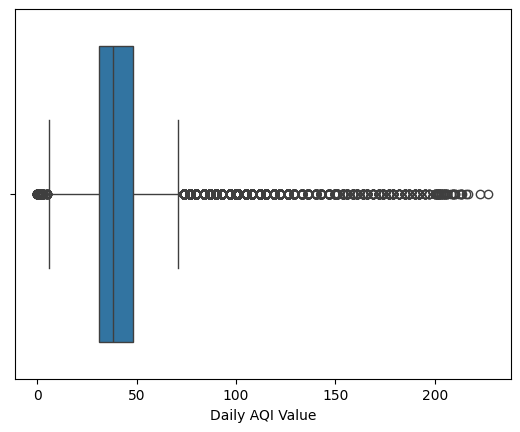

In [37]:
# Checking Daily AQI Value
# Plotting in a boxplot to check for outliers
sns.boxplot(data=df,
            x='Daily AQI Value');

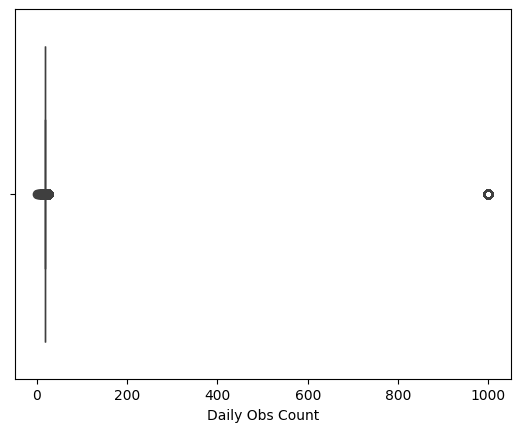

In [41]:
# Plotting daily obs count with a boxplot to check for outliers
sns.boxplot(data=df,
            x='Daily Obs Count');

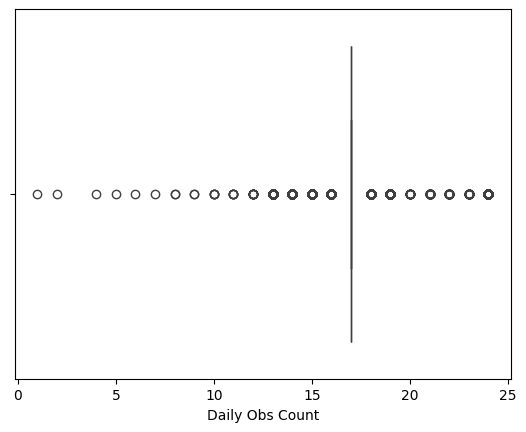

In [42]:
# Remove outlier at 1000 and replot
df = df[df['Daily Obs Count'] < 200]
sns.boxplot(data=df,
            x='Daily Obs Count');

In [58]:
# There are 2 distinct entries for Los Angeles and San Francisco in the county column
# the other being entries being LA and SF
# Replace accordingly
df['County'] = df['County'].str.replace('LA', 'Los Angeles')
df['County'] = df['County'].str.replace('SF', 'San Francisco')

In [60]:
df['Method Code'].unique()

array([ 47.,  nan,  87., 199.,  53.])